In [2]:
import pandas as pd
df = pd.read_csv("./data.csv")
df

,spec,comb,test,down,solutions,limit_test,limit_down,limit_solutions
0,12108445569812518508,12442017376455845525,10,5,1,10,6,2
1,12108445569812518508,10852793995559917114,36,16,4,36,20,8
2,12108445569812518508,16503017991964024325,20,10,2,20,12,4
3,12108445569812518508,1804336183759063808,18,8,2,18,10,4
4,12108445569812518508,4580224252362903624,20,12,4,20,12,4
...,...,...,...,...,...,...,...,...
11024939,195584078970860229,18265928219219123828,210,90,16,722,382,128
11024940,195584078970860229,11156210153028826546,386,162,32,754,382,128
11024941,195584078970860229,815542084371820574,234,102,16,682,382,128
11024942,195584078970860229,8649753424313886374,250,110,16,666,382,128


In [3]:
maximums = df.groupby(["spec"]).max().loc[:, "test":].add_prefix("max_")
maximums

,max_test,max_down,max_solutions,max_limit_test,max_limit_down,max_limit_solutions
spec,,,,,,
301835926428081,1748,628,128,3796,2036,1024
508021490768885,1242,438,128,2010,1014,512
798266467397644,1620,564,128,3796,2036,1024
923855370466336,620,220,64,1004,508,256
998300281352198,2132,724,128,4436,2260,1024
...,...,...,...,...,...,...
18444610594649227649,2260,724,128,7892,4052,2048
18445059513860439354,1964,620,128,4012,2028,1024
18445651354439083033,1428,500,128,3988,2036,1024


In [4]:
squished = pd.read_csv("./squished.csv").set_index("spec").add_suffix("_squished")
squished

,limit_test_squished,limit_down_squished,limit_solutions_squished,approx_test_squished,approx_down_squished,approx_solutions_squished
spec,,,,,,
12108445569812518508,44,28,16,44,24,12
13295520056715543416,48,28,16,40,22,12
849832514006898133,44,28,16,44,24,12
2242271814187683694,48,28,16,40,22,12
14543158900860426855,39,21,12,39,21,12
...,...,...,...,...,...,...
7649607811187125407,1527,765,384,1527,765,384
2857005462797260995,2679,1437,768,2679,1437,768
5869025830373567016,2679,1437,768,2679,1437,768


In [5]:
out = maximums.join(squished, on="spec").sort_values("max_test")
out

,max_test,max_down,max_solutions,max_limit_test,max_limit_down,max_limit_solutions,limit_test_squished,limit_down_squished,limit_solutions_squished,approx_test_squished,approx_down_squished,approx_solutions_squished
spec,,,,,,,,,,,,
14543158900860426855,26,10,4,26,14,8,39,21,12,39,21,12
4281292345261825678,26,10,4,26,14,8,39,21,12,39,21,12
2242271814187683694,28,12,4,44,28,16,48,28,16,40,22,12
13295520056715543416,28,12,4,28,16,8,48,28,16,40,22,12
849832514006898133,36,16,4,36,20,8,44,28,16,44,24,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2952355564590866619,3924,1236,128,11604,5972,2048,13652,8020,4096,13652,6996,3072
2329299738473722938,3924,1236,128,11604,5972,2048,13652,8020,4096,13652,6996,3072
18107186453861008530,3924,1236,128,11604,5972,2048,13652,8020,4096,13652,6996,3072


In [6]:
s = pd.Series(list(range(len(out))))
out = out.set_index(s)
out

,max_test,max_down,max_solutions,max_limit_test,max_limit_down,max_limit_solutions,limit_test_squished,limit_down_squished,limit_solutions_squished,approx_test_squished,approx_down_squished,approx_solutions_squished
0,26,10,4,26,14,8,39,21,12,39,21,12
1,26,10,4,26,14,8,39,21,12,39,21,12
2,28,12,4,44,28,16,48,28,16,40,22,12
3,28,12,4,28,16,8,48,28,16,40,22,12
4,36,16,4,36,20,8,44,28,16,44,24,12
...,...,...,...,...,...,...,...,...,...,...,...,...
46225,3924,1236,128,11604,5972,2048,13652,8020,4096,13652,6996,3072
46226,3924,1236,128,11604,5972,2048,13652,8020,4096,13652,6996,3072
46227,3924,1236,128,11604,5972,2048,13652,8020,4096,13652,6996,3072
46228,3924,1236,128,11604,5972,2048,13652,8020,4096,13652,6996,3072


<AxesSubplot:>

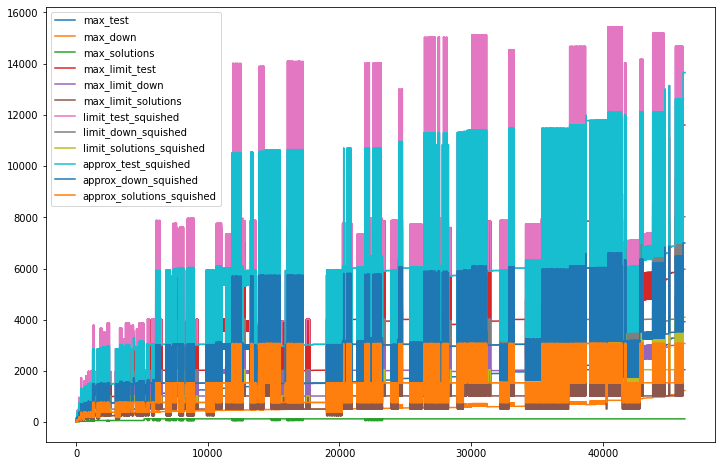

In [7]:
out.plot(figsize=(12,8))

<AxesSubplot:>

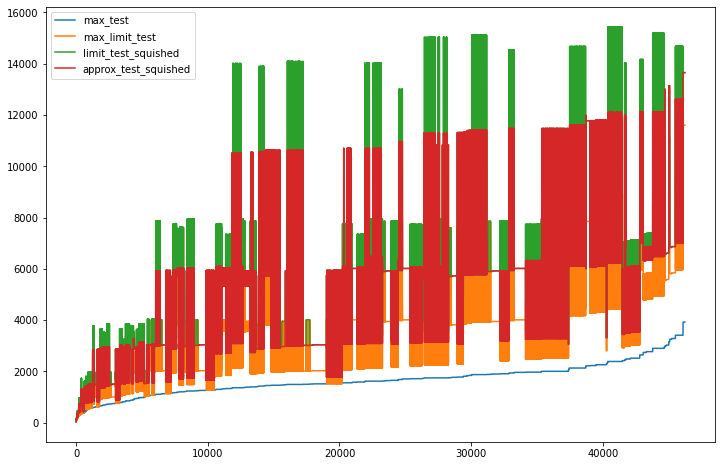

In [8]:
out.loc[:, ["max_test", "max_limit_test", "limit_test_squished", "approx_test_squished"]]\
    .plot(figsize=(12,8))

<AxesSubplot:>

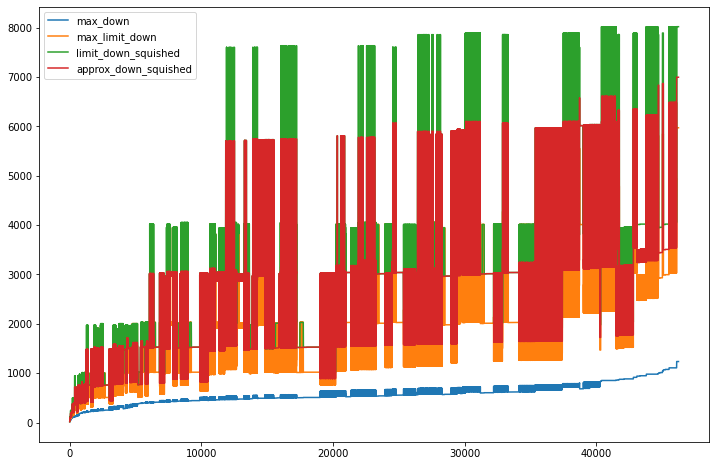

In [9]:
out.loc[:, ["max_down", "max_limit_down", "limit_down_squished", "approx_down_squished"]]\
    .plot(figsize=(12,8))


<AxesSubplot:>

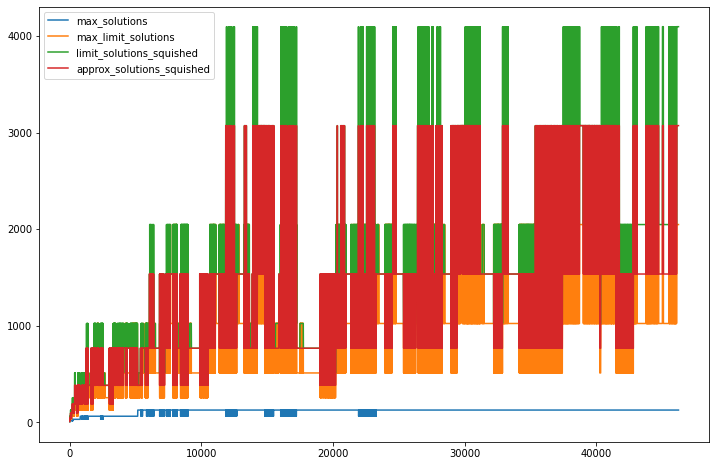

In [10]:
out.loc[:, ["max_solutions", "max_limit_solutions", "limit_solutions_squished", "approx_solutions_squished"]]\
    .plot(figsize=(12,8))


<AxesSubplot:>

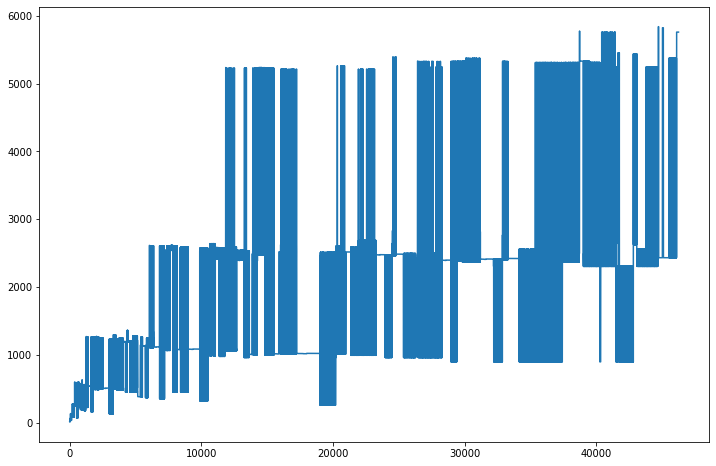

In [15]:
(out["approx_down_squished"] - out["max_down"]).plot(figsize=(12,8))